In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve2d, fftconvolve

In [3]:
camara_pixel_size = 5000 # nm
camara_pixels_number = 512
camara_size = camara_pixel_size * camara_pixels_number 
NA = 1.25 # numerical aperture
MA = 500 # magnification
collect_number = 800 # number of collected photos
physical_pixel_size = camara_pixel_size / MA 
physical_size = camara_size / MA 
excitation_wavelength = 488 # nm
emission_wavelength = 520 # nm
#diffraction_limit = 0.61 * wavelength / NA 

In [4]:
def generate_psf(camara_pixels_number, physical_pixel_size, wavelength, NA):
    # 计算频率范围
    freq = np.fft.fftfreq(camara_pixels_number, d=physical_pixel_size/2)#这里为什么除2我也不知道
    fx, fy = np.meshgrid(freq, freq)
    f_r = np.sqrt(fx**2 + fy**2)
    
    # 计算截止频率
    cutoff_frequency = 2 * NA / wavelength
    
    # 生成光瞳函数
    pupil_function = f_r <= cutoff_frequency

    # 计算点扩散函数
    psf = np.abs(ifftshift(ifft2(fftshift(pupil_function))))**2
    psf /= psf.max()  
    
    return psf

In [5]:
line_pairs_spacing = [60, 80, 100, 120, 140, 160, 180, 200] # nm
line_pairs_spacing = np.array(line_pairs_spacing)
line_pairs_spacing_by_pixel = line_pairs_spacing * MA / camara_pixel_size    # in pixel size

In [6]:
def generate_line_pairs(camara_pixels_number, line_spacing_by_pixel = 20, line_width = 1, line_length = 300):
    
    # 创建一个的黑色图像
    image_array = np.zeros((camara_pixels_number, camara_pixels_number//8))

    # 线的间距和宽度和长度
    line_spacing_by_pixel = round(line_spacing_by_pixel)
    line_width = round(line_width)
    line_length = round(line_length)
    
    # 计算线的位置
    center_x = image_array.shape[1] // 2
    center_y = image_array.shape[0] // 2

    # 第一条线的起始和结束位置
    line1_start_x = center_x - round(line_spacing_by_pixel / 2) - line_width
    line1_end_x = line1_start_x + line_width
    line1_start_y = center_y - line_length // 2
    line1_end_y = line1_start_y + line_length

    # 第二条线的起始和结束位置
    line2_start_x = center_x + round(line_spacing_by_pixel / 2)
    line2_end_x = line2_start_x + line_width
    line2_start_y = center_y - line_length // 2
    line2_end_y = line2_start_y + line_length

    # 绘制第一条线
    image_array[line1_start_y:line1_end_y, line1_start_x:line1_end_x] = 1

    # 绘制第二条线
    image_array[line2_start_y:line2_end_y, line2_start_x:line2_end_x] = 1
    
    return image_array

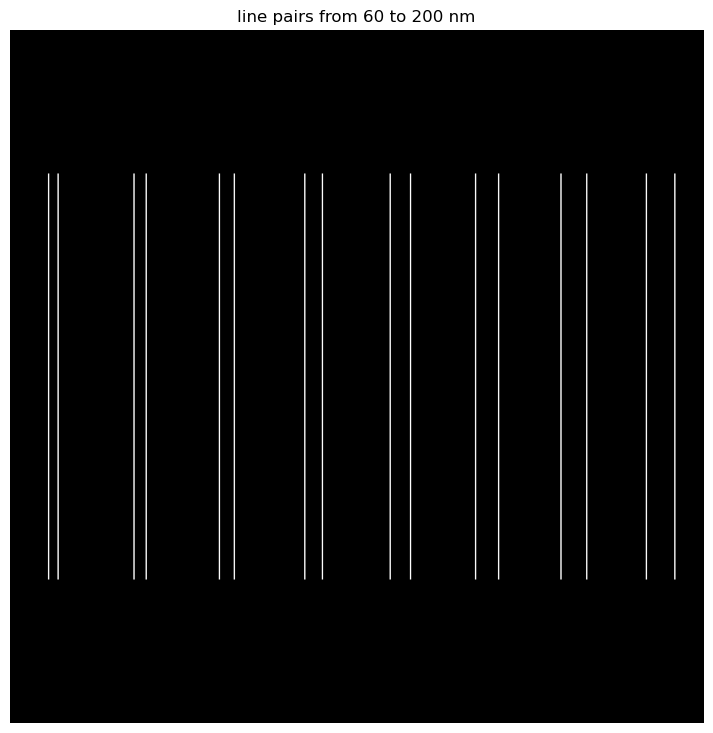

In [7]:
images = [generate_line_pairs(camara_pixels_number, spacing) for spacing in line_pairs_spacing_by_pixel]

#ground_truth = images[5]
ground_truth = np.hstack(images)
plt.figure(figsize=(18, 9))
plt.imshow(ground_truth, cmap='gray')
plt.title(f"line pairs from {line_pairs_spacing.min()} to {line_pairs_spacing.max()} nm")
plt.axis('off')
plt.show()

float64
1.0


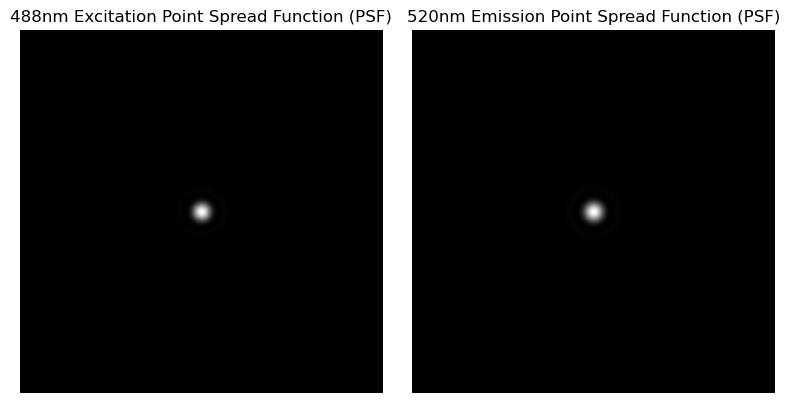

In [25]:
excitation_psf = generate_psf(camara_pixels_number, physical_pixel_size, excitation_wavelength, NA)
emission_psf = generate_psf(camara_pixels_number, physical_pixel_size, emission_wavelength, NA)

print(excitation_psf.dtype)
print(np.max(excitation_psf))
# 显示激发点扩散函数和发射点扩散函数并列
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# 激发点扩散函数
axes[0].imshow(excitation_psf, cmap='gray')
axes[0].set_title(f"{excitation_wavelength}nm Excitation Point Spread Function (PSF)")
axes[0].axis('off')

# 发射点扩散函数
axes[1].imshow(emission_psf, cmap='gray')
axes[1].set_title(f"{emission_wavelength}nm Emission Point Spread Function (PSF)")
axes[1].axis('off')

image = Image.fromarray(np.uint32(excitation_psf * 2**31-1))
image.save('PSF512_488nm.tif')


plt.tight_layout()
plt.show()

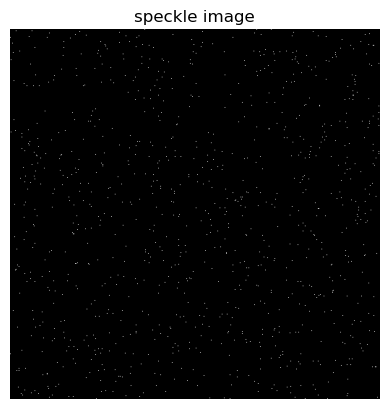

In [14]:
speckle_image = np.zeros((camara_pixels_number, camara_pixels_number))
speckle_images = np.zeros((collect_number, camara_pixels_number, camara_pixels_number))
num_speckles = 1000 # 每张图像中的散斑数量

for i in range(collect_number):
    indices = np.random.choice(camara_pixels_number * camara_pixels_number, num_speckles, replace=False)
    speckle_image[np.unravel_index(indices, (camara_pixels_number, camara_pixels_number))] = 1
    speckle_images[i, :, :] = speckle_image.copy()
    speckle_image.fill(0)  # 清空图像以便下次使用
# 显示随机散斑图片
#plt.figure(figsize=(18, 9))
plt.imshow(speckle_images[400, :, :], cmap='gray')
plt.title("speckle image")
plt.axis('off')  # 不显示坐标轴
plt.show()

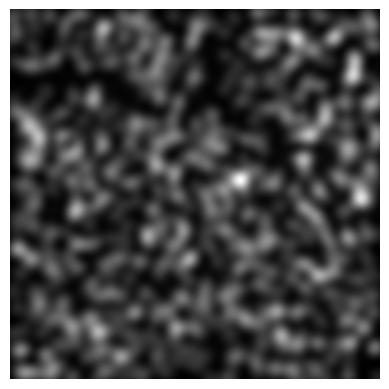

In [17]:
# 对散斑图片进行卷积
convolved_speckle_images = np.zeros((collect_number, camara_pixels_number, camara_pixels_number))
for i in range(collect_number):
    convolved_speckle_image = fftconvolve(speckle_images[i, :, :], excitation_psf, mode='same')
    convolved_speckle_images[i, :, :] = convolved_speckle_image.copy()
    convolved_speckle_image.fill(0)  # 清空图像以便下次使用
#convolved_speckle_image = fft2(fftshift(speckle_image)) * fft2(fftshift(excitation_psf))
#convolved_speckle_image = ifftshift(ifft2(convolved_speckle_image).real)

# 显示卷积后的图像
#plt.figure(figsize=(18, 9))
plt.imshow(convolved_speckle_images[400, :, :], cmap='gray')
plt.axis('off')  # 不显示坐标轴
plt.show()

# 存储为8位灰度图像tiff格式
# image = Image.fromarray(convolved_speckle_image)
# image.save('speckle_convolve.tif')

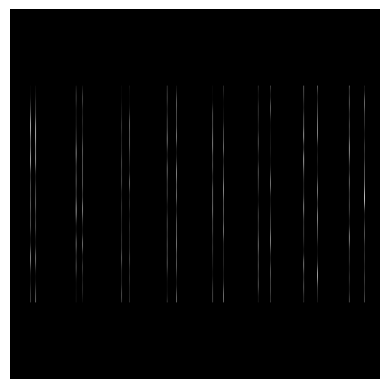

In [19]:
illuminate_images = np.zeros((collect_number, camara_pixels_number, camara_pixels_number))
for i in range(collect_number):
    illuminate_images[i, :, :] = convolved_speckle_images[i, :, :] * ground_truth

# 展示结果图像
plt.imshow(illuminate_images[400, :, :], cmap='gray')
plt.axis('off')  # 不显示坐标轴
plt.show()

# 存储为8位灰度图像tiff格式
# image = Image.fromarray(np.uint8(illuminate_images[400, :, :]*255))
# image.save('sample_illu.tif')

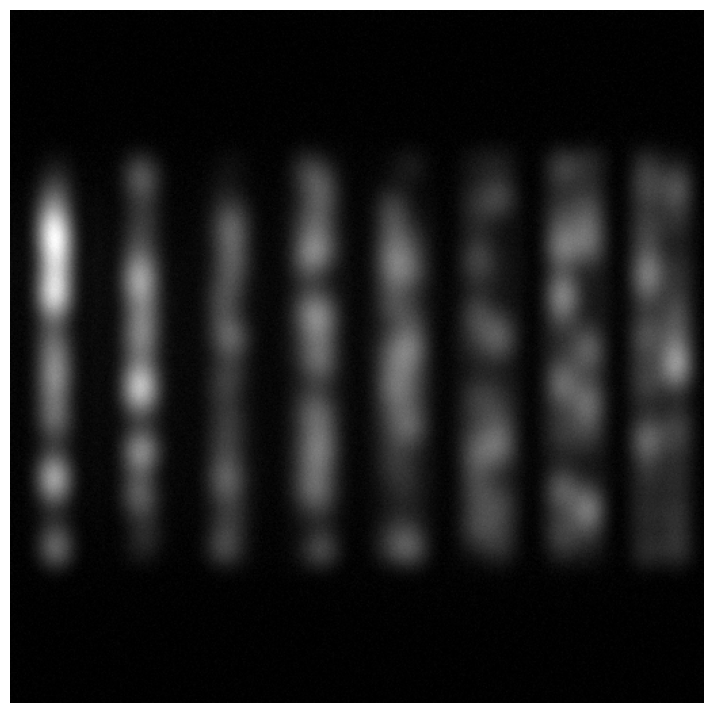

In [ ]:
from tifffile import imwrite

collected_images = np.zeros((collect_number, camara_pixels_number, camara_pixels_number))
for i in range(collect_number):
    collected_images[i, :, :] = fftconvolve(illuminate_images[i, :, :], emission_psf, mode='same')
    collected_images[i, :, :] = abs(np.random.normal(collected_images[i, :, :], 0.01*collected_images[i, :, :].max()))
    collected_images[i, :, :] = collected_images[i, :, :]/np.max(collected_images[i, :, :]) * 2**20
    collected_images[i, :, :] = np.clip(collected_images[i, :, :], 0, 1e10)  # 限制数据范围
    collected_images[i, :, :] = np.random.poisson(collected_images[i, :, :])

# collected_image = fft2(fftshift(illuminate_image)) * fft2(fftshift(emission_psf)) 
# collected_image = ifftshift(ifft2(collected_image).real)
imwrite('collected_images.tiff', collected_images.astype(np.uint32))
# 显示卷积后的图像
plt.figure(figsize=(18, 9)) 
plt.imshow(collected_images[400, :, :], cmap='gray')
plt.axis('off')  # 不显示坐标轴
plt.show()


0.08087319414329949


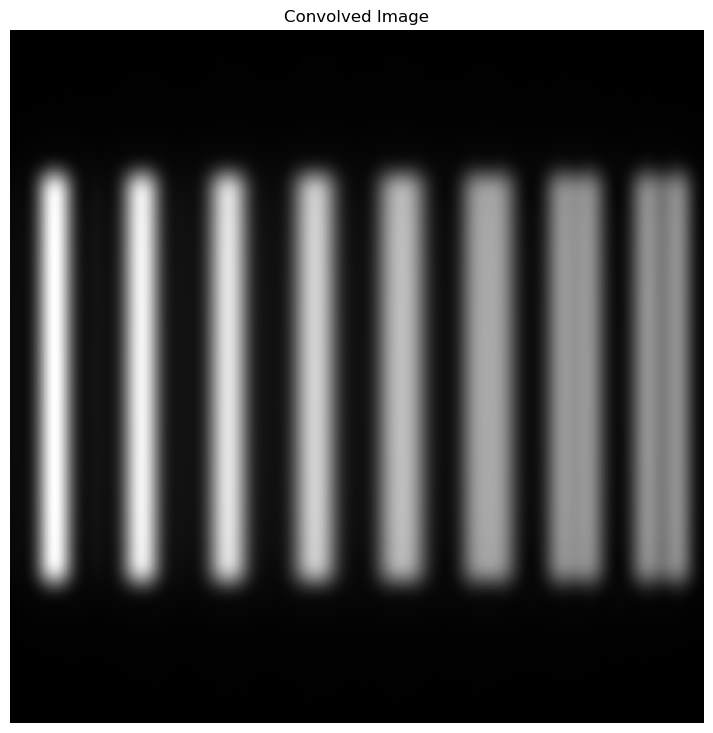

In [206]:
# 对 ground_truth 和 psf 进行卷积
convolved_image = fftconvolve(ground_truth, excitation_psf, mode='same')
print(np.max(convolved_image))
# 显示卷积后的图像
plt.figure(figsize=(18, 9))
plt.imshow(convolved_image, cmap='gray')
plt.title("Convolved Image")
plt.axis('off')
plt.show()

In [11]:
sizeImage = 256;
X, Y = np.meshgrid(np.arange(-sizeImage/2, sizeImage/2),np.arange(-sizeImage/2, sizeImage/2));
R = np.sqrt(X**2 + Y**2);